# Linear models in Keras

In [1]:
import theano
from theano.sandbox import cuda
theano.sandbox.cuda.use("gpu0")

/home/irashadow/.pyenv/versions/miniconda-3.9.1/lib/python2.7/site-packages/theano/sandbox/cuda/__init__.py:541: UserWarning: Theano flag device=gpu* (old gpu back-end) only support floatX=float32. You have floatX=float64. Use the new gpu back-end with device=cuda* for that value of floatX.
  warnings.warn(msg)
Using gpu device 0: Tesla K80 (CNMeM is disabled, cuDNN 4007)


In [26]:
%matplotlib inline
import utils; reload(utils)
from utils import *

In [3]:
x = random((30,2))
y = np.dot(x, [2., 3.]) + 1.

In [4]:
x[:5]

array([[ 0.4991,  0.8699],
       [ 0.2255,  0.3724],
       [ 0.2187,  0.861 ],
       [ 0.7387,  0.1383],
       [ 0.229 ,  0.5722]])

In [5]:
y[:5]

array([ 4.6081,  2.5682,  4.0204,  2.8923,  3.1744])

In [6]:
lm = Sequential([ Dense(1, input_shape=(2,))])
lm.compile(optimizer=SGD(lr=0.1), loss = 'mse')

In [7]:
lm.evaluate(x, y, verbose = 0)

19.832939147949219

In [9]:
lm.get_weights()

[array([[-0.3162],
        [-0.734 ]], dtype=float32), array([ 0.], dtype=float32)]

In [12]:
lm.fit(x, y, nb_epoch=5, batch_size = 1)

Epoch 1/5
30/30 [==============================] - 0s - loss: 0.0096     
Epoch 2/5
30/30 [==============================] - 0s - loss: 0.0046     
Epoch 3/5
30/30 [==============================] - 0s - loss: 0.0021     
Epoch 4/5
30/30 [==============================] - 0s - loss: 9.3706e-04 
Epoch 5/5
30/30 [==============================] - 0s - loss: 4.4664e-04     


In [13]:
lm.evaluate(x, y, verbose = 0)

0.00022208085283637047

# Train linear model on predictions

We now know enough to understand how to modify Vgg16 to create a model that will output predictions for Cats and Dogs. Follow along in the lesson 2 notebook to be able to reproduce what we're going to do.

# Adding a Dense Layer
The dense layer we used in the last section mapped input vectors to a single output. We can easily change this to output to a vector of arbitrary length, noting that the structure of the weights for such an output will be just a matrix like we talked about earlier.

The last layer of Vgg16 outputs a vector of 1000 categories, because that is the number of categories the competition asked for. Of these categories, some of them certainly correspond to cats and dogs, but at a much more granular level (specific breeds). We could manually figure out which of these categories are cats and which are dogs, and simply write some code that will translate the imagenet classifications into a cat and dog classification. But that would be inefficient, and we would miss some key information.

A better approach would be to simply add a Dense layer on top of the imagenet layer, and train the model to map the imagenet classifications of input images of cats and dogs to cat and dog labels. Why is this better than manually doing it? Because the neural network will utilize all information available to it from the imagenet classifications, as opposed to simply mapping cat categories to cat and dog categories to dog. For example, a picture of a german sheperd with a bone would likely have strong probabilities in the german sheperd category and the bone category. If we only map the dog categories to dog, and throw out the rest, then we lose this other information useful in classification, such as whether or not a bone is in the image.



In [115]:
from vgg16 import Vgg16
vgg = Vgg16()
model = vgg.model

/home/irashadow/.pyenv/versions/miniconda-3.9.1/lib/python2.7/site-packages/keras/layers/core.py:577: UserWarning: `output_shape` argument not specified for layer lambda_4 and cannot be automatically inferred with the Theano backend. Defaulting to output shape `(None, 3, 224, 224)` (same as input shape). If the expected output shape is different, specify it via the `output_shape` argument.
  .format(self.name, input_shape))


In [50]:
batch_size = 64

Our overall approach here will be:  

1. Get the true labels for every image  
2. Get the 1,000 imagenet category predictions for every image  
3. Feed these predictions as input to a simple linear model. 

The lesson 2 notebook shows us again how to grab our batches. One important point to note is that the labels we get from our batches need to be one-hot encoded. One hot encoding simply takes categorical variables, and converts them into a matrix where each column represents a category. If an image belongs to category A, that image's row in the matrix has a 1 in the category A column and 0's every else. One important reason we take the step to convert our labels to these vectors is because this is the same shape as the output of our dense layer. Therefore for training purposes we need to one-hot encode them. Now we can predict.

In [15]:
path = '/home/irashadow/python_workspace/deep_learning_workspace/data/DogAndCat/'
val_batches = get_batches(path+'valid',shuffle=False, batch_size=1)
batches = get_batches(path+'train',shuffle=False, batch_size=1)

Found 2000 images belonging to 2 classes.
Found 23000 images belonging to 2 classes.


In [16]:
import bcolz
def save_array(fname, arr): c=bcolz.carray(arr, rootdir=fname, mode='w'); c.flush()
def load_array(fname): return bcolz.open(fname)[:]    

In [27]:
??get_data_batches

In [28]:
val_data = get_data_batches(val_batches)

In [29]:
trn_data = get_data_batches(batches)

In [30]:
save_array(path+'models/train_data.bc', trn_data)
save_array(path+'models/valid_data.bc', val_data)

In [33]:
trn_data = load_array(path+'models/train_data.bc')
val_data = load_array(path+'models/valid_data.bc')

In [43]:
val_data.shape

(2000, 3, 224, 224)

Keras returns classes as a single column, so we convert to one hot encoding

In [44]:
def onehot(x): return np.array(OneHotEncoder().fit_transform(x.reshape(-1,1)).todense())

In [45]:
val_classes = val_batches.classes
trn_classes = batches.classes
val_labels = onehot(val_classes)
trn_labels = onehot(trn_classes)

In [46]:
trn_labels.shape

(23000, 2)

In [47]:
trn_classes[:4]

array([0, 0, 0, 0], dtype=int32)

In [48]:
trn_labels[:4]

array([[ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.]])

In [59]:
trn_features = model.predict(trn_data, batch_size=batch_size)
val_features = model.predict(val_data, batch_size=batch_size)

In [60]:
save_array(path+'models/train_lastlayer_features.bc', trn_features)
save_array(path+'models/valid_lastlayer_features.bc', val_features)

In [61]:
trn_features = load_array(path+'models/train_lastlayer_features.bc')
val_features = load_array(path+'models/valid_lastlayer_features.bc')

In [62]:
print trn_features.shape

(23000, 1000)


In [116]:
#1000 inputs, since that's saved features, and 2 outputs, for dog and cat
lm = Sequential([ Dense(2, activation='softmax', input_shape=(1000,)) ])
lm.compile(optimizer=RMSprop(lr=0.1), loss = 'categorical_crossentropy', metrics=['accuracy'])

In [117]:
batch_size = 64

In [65]:
lm.fit(trn_features, trn_labels, nb_epoch=3, batch_size=batch_size, validation_data=(val_features, val_labels))

Train on 23000 samples, validate on 2000 samples
Epoch 1/3
23000/23000 [==============================] - 0s - loss: 0.0991 - acc: 0.9656 - val_loss: 0.0781 - val_acc: 0.9750
Epoch 2/3
23000/23000 [==============================] - 0s - loss: 0.0829 - acc: 0.9737 - val_loss: 0.0767 - val_acc: 0.9770
Epoch 3/3
23000/23000 [==============================] - 0s - loss: 0.0833 - acc: 0.9761 - val_loss: 0.0828 - val_acc: 0.9770


In [66]:
lm.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
dense_6 (Dense)                  (None, 2)             2002        dense_input_3[0][0]              
Total params: 2,002
Trainable params: 2,002
Non-trainable params: 0
____________________________________________________________________________________________________


Do you remember how we defined our linear model? Here it is again for reference:

In [118]:
lm = Sequential([ Dense(2, activation='softmax', input_shape=(1000,)) ])

And do you remember the definition of a fully connected layer in the original VGG?:

In [119]:
model.add(Dense(4096, activation='relu'))

# Finetuning
If we observe the last layer of Vgg16, we can see that the last layer is simply a dense layer that outputs 1000 elements, which is as we'd expect. Therefore, it seems somewhat unreasonable to stack a dense layer meant to find cats and dogs on top of one that's meant to find imagenet categories, in that we're limiting the information available to us by first coercing the neural network to classify to imagenet before cats and dogs.

Instead, let's remove that last layer.



In [129]:
vgg.model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_4 (Lambda)                (None, 3, 224, 224)   0           lambda_input_4[0][0]             
____________________________________________________________________________________________________
zeropadding2d_40 (ZeroPadding2D) (None, 3, 226, 226)   0           lambda_4[0][0]                   
____________________________________________________________________________________________________
convolution2d_40 (Convolution2D) (None, 64, 224, 224)  1792        zeropadding2d_40[0][0]           
____________________________________________________________________________________________________
zeropadding2d_41 (ZeroPadding2D) (None, 64, 226, 226)  0           convolution2d_40[0][0]           
___________________________________________________________________________________________

In [126]:
#remove last layer
model.pop()
for layer in model.layers: layer.trainable=False

In [128]:
model.add(Dense(2, activation='softmax'))

In [75]:
gen=image.ImageDataGenerator()
batches = gen.flow(trn_data, trn_labels, batch_size=batch_size, shuffle=True)
val_batches = gen.flow(val_data, val_labels, batch_size=batch_size, shuffle=False)

In [77]:
??vgg.finetune

In [130]:
opt = RMSprop(lr=0.1)
model.compile(optimizer=opt, loss = 'categorical_crossentropy', metrics=['accuracy'])

In [131]:
def fit_model(model, batches, val_batches, nb_epoch=1):
    model.fit_generator(batches, samples_per_epoch=batches.N, nb_epoch=nb_epoch, 
                        validation_data=val_batches, nb_val_samples=val_batches.N)

In [ ]:
fit_model(model,batches,val_batches,nb_epoch=2)

Epoch 1/2
 3968/23000 [====>.........................] - ETA: 456s - loss: 0.8280 - acc: 0.9413

In [84]:
model.save_weights(path+'models/finetune1.h5')

In [85]:
model.load_weights(path+'models/finetune1.h5')

In [86]:
model.evaluate(val_data, val_labels)

2000/2000 [==============================] - 48s    


[0.080610379279838523, 0.97799999999999998]

In [87]:
preds = model.predict_classes(val_data, batch_size=batch_size)
probs = model.predict_proba(val_data, batch_size=batch_size)[:,0]
probs[:8]

2000/2000 [==============================] - 48s    


array([ 1.    ,  1.    ,  0.5166,  1.    ,  1.    ,  1.    ,  1.    ,  1.    ], dtype=float32)

In [124]:
cm = confusion_matrix(val_classes, preds)

[[1030   17]
 [  27  926]]


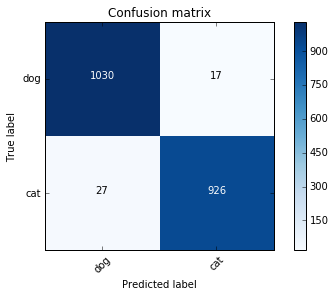

In [89]:
plot_confusion_matrix(cm, {'cat':0, 'dog':1})